In [1]:
%matplotlib inline

from typing import Optional, Union

import os
import sys
import argparse

import torch
import torchvision
from torch import Tensor
import torch.nn.functional as F
from torchvision.ops import boxes as box_ops
from torchvision.ops.boxes import box_area
from torchvision.ops.roi_align import _bilinear_interpolate, roi_align
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

import numpy as np
import matplotlib.pyplot as plt


torch.manual_seed(0)
np.random.seed(0)

In [2]:
# if run in Google colab
!wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip -P data
#!cd data && unzip PennFudanPed.zip
!cd data
!nohup unzip data/PennFudanPed.zip

!git clone https://github.com/s-reaungamornrat/video_processing.git

main_dirpath=''

--2025-09-08 06:28:20--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘data/PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M  31.9MB/s    in 1.6s    

2025-09-08 06:28:22 (31.9 MB/s) - ‘data/PennFudanPed.zip’ saved [53723336/53723336]

nohup: ignoring input and appending output to 'nohup.out'
Cloning into 'video_processing'...
remote: Enumerating objects: 159, done.
remote: Counting objects: 100% (159/159), done.
remote: Compressing objects: 100% (95/95), done.
remote: Total 159 (delta 62), reused 139 (delta 46), pack-reused 0 (from 0)
Receiving objects: 100% (159/159), 14.46 MiB | 35.85 MiB/s, done.
Resolving deltas: 100% (62/62), done.


In [3]:
# Create the parser
parser = argparse.ArgumentParser(description='MaskRCNN')

# Add arguments
parser.add_argument('--rpn-objectness-weight', type=float, default=10., help='weight to the loss of RPN objectness')
parser.add_argument('--rpn-box-regression-weight', type=float, default=50., help='weight to the loss of RPN box regression')
parser.add_argument('--roi-classifier-weight', type=float, default=1., help='weight to the loss of roi-head for object class')
parser.add_argument('--roi-box-regression-weight', type=float, default=5., help='weight to the loss for roi-head box regression')
parser.add_argument('--mask-weight', type=float, default=0.5, help='weight to mask loss')
parser.add_argument('--n-training', type=int, default=160, help='number of training data')
parser.add_argument('--max-epochs', type=int, default=160, help='maximum number of epochs')
parser.add_argument('--print-freq', type=int, default=5, help='how many batch before printing')

args = parser.parse_args('--max-epochs 50  --print-freq 20'.split())
args

Namespace(rpn_objectness_weight=10.0, rpn_box_regression_weight=50.0, roi_classifier_weight=1.0, roi_box_regression_weight=5.0, mask_weight=0.5, n_training=160, max_epochs=50, print_freq=20)

In [4]:
device=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('device ', device)

device  cuda


In [5]:
!pip install wget

import wget
main_url='https://raw.githubusercontent.com/pytorch/vision/main/references/detection'
for file in ['engine.py', 'utils.py','coco_utils.py','coco_eval.py', 'transforms.py']:
    if os.path.isfile(file): continue
    out=wget.download(url=f'{main_url}/{file}', out=None)
    print(file, out)

import utils

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=5c55b6dc8ae9bed2e74471e2df33db7472a796e223b00465e18a1ff2b3bce79d
  Stored in directory: /root/.cache/pip/wheels/01/46/3b/e29ffbe4ebe614ff224bad40fc6a5773a67a163251585a13a9
Successfully built wget
engine.py engine.py
utils.py utils.py
coco_utils.py coco_utils.py
coco_eval.py coco_eval.py
transforms.py transforms.py


In [6]:
num_classes=2
# load an instance segmentation model pre-trained on COCO
model=torchvision.models.detection.maskrcnn_resnet50_fpn_v2(weights='DEFAULT', rpn_pre_nms_top_n_train=800,
        rpn_pre_nms_top_n_test=500,  rpn_post_nms_top_n_train=800,  rpn_post_nms_top_n_test=500, box_detections_per_img=100,
        box_batch_size_per_image =400, rpn_batch_size_per_image=100)
# get number of input features for the classifier
in_features=model.roi_heads.box_predictor.cls_score.in_features
print('the number of inpute features for classifiers ', in_features)
# replace the pre-trained head with a new one
model.roi_heads.box_predictor=FastRCNNPredictor(in_features,  num_classes)

# get the number of input features for the mask classifiers
in_features_mask=model.roi_heads.mask_predictor.conv5_mask.in_channels
print('the number of input features for mask ', in_features_mask)
hidden_layer=256
# and replace the mask predictor with a new one
model.roi_heads.mask_predictor=MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

# move model to the right device
model.to(device);

# we create optimizer after load state and pass model to correct device
optimizer=torch.optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), weight_decay=0.01)


Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth


100%|██████████| 177M/177M [00:01<00:00, 142MB/s]


the number of inpute features for classifiers  1024
the number of input features for mask  256


In [7]:
from video_processing.mask_rcnn.dataset.penn_fudan_ped import PennFudanDataset, get_transform

# there are 170 images
train_dataset=PennFudanDataset(root=os.path.join(main_dirpath, 'PennFudanPed'), image_dirname='PNGImages', mask_dirname='PedMasks',
                               annotation_dirname='Annotation', transforms=get_transform(is_train=True), indices=np.arange(160))
val_dataset=PennFudanDataset(root=os.path.join(main_dirpath, 'PennFudanPed'), image_dirname='PNGImages', mask_dirname='PedMasks',
                               annotation_dirname='Annotation', transforms=get_transform(is_train=False), indices=np.arange(160,170))
print('train_dataset ', len(train_dataset), ' val_dataset ', len(val_dataset))
# define training and validation data loaders
train_loader=torch.utils.data.DataLoader(train_dataset, batch_size=2,shuffle=True,collate_fn=utils.collate_fn)
val_loader=torch.utils.data.DataLoader(val_dataset, batch_size=2,shuffle=False,collate_fn=utils.collate_fn)

train_dataset  160  val_dataset  10


In [9]:
def train_epoch(model, train_loader, optimizer,weights, device, print_freq=1):

    running_loss=0.
    for i, (images, targets) in enumerate(train_loader, 1):
        # port data to device
        images=[im.to(device) for im in images]
        targets=[{k:v.to(device) if isinstance(v, torch.Tensor) else v for k, v in target.items()} for target in targets]

        # zero gradients
        optimizer.zero_grad()

        # estimate
        outputs=model(images, targets)

        # compute loss
        loss, log=0., ''
        for name, loss_term in outputs.items():
            loss+=weights[name]*loss_term
            log+=f' {name}:{loss.item():.3f},'
        loss.backward()

        # adjusting parameters
        optimizer.step()

        # gather data and report
        running_loss+=loss.item()
        if print_freq>0 and i%print_freq==0:
            print(f'\tIteration {i} [{100*i/len(train_loader):.2f}%]: total:{loss.item():.3f}, {log}')
    last_loss=running_loss/len(train_loader)
    return last_loss

def validation(model, val_loader, weights, device):
    running_loss, loss_per_task=0., dict()
    for i, (images, targets) in enumerate(val_loader, 1):

        # port data to device
        images=[im.to(device) for im in images]
        targets=[{k:v.to(device) if isinstance(v, torch.Tensor) else v for k, v in target.items()} for target in targets]

        with torch.no_grad(): outputs=model(images, targets)
        # compute loss
        loss=0
        for name, loss_term in outputs.items():
            loss+=weights[name]*loss_term
            if name not in loss_per_task: loss_per_task[name]=0.
            loss_per_task[name]+=loss_term.item()
        running_loss+=loss.item()
        break
    loss/=len(val_loader)
    loss_per_task={k:n/len(val_loader) for k, n in loss_per_task.items()}
    return loss, loss_per_task

In [10]:
weights={'loss_classifier':args.roi_classifier_weight, 'loss_box_reg':args.roi_box_regression_weight,
         'loss_mask':args.mask_weight,'loss_objectness':args.rpn_objectness_weight,
         'loss_rpn_box_reg':args.rpn_box_regression_weight}

model.train()
best_vloss=np.inf
train_losses, val_losses=[],[]
for epoch in range(1, args.max_epochs+1):
    # make sure gradient tracking is on
    t_loss=train_epoch(model, train_loader, optimizer, weights=weights, device=device, print_freq=args.print_freq)

    # validation
    v_loss, v_loss_per_task=validation(model, val_loader, weights=weights, device=device)

    # record training measures
    train_losses+=[t_loss.detach().cpu()]
    val_losses+=[v_loss.cpu()]

    # print progress
    log=''
    for k, v in v_loss_per_task.items(): log+=f' {k}:{v:.2f},'
    print(f'Epoch {epoch} [{100.*epoch/args.max_epochs}:.2f]: training loss {t_loss:.3f}, val_loss: {v_loss:.3f}, {log}')

    if v_loss<best_vloss and epoch>1:
        best_vloss=v_loss
        torch.save(model.state_dict(), f'best_checkpoint.pth')

    torch.save(model.state_dict(), 'checkpoint.pth')

	Iteration 20 [25.000000%]: total:4.075,  loss_classifier:0.186, loss_box_reg:0.936, loss_mask:1.171, loss_objectness:1.703, loss_rpn_box_reg:4.075,
	Iteration 40 [50.000000%]: total:6.689,  loss_classifier:0.202, loss_box_reg:1.508, loss_mask:1.797, loss_objectness:2.290, loss_rpn_box_reg:6.689,
	Iteration 60 [75.000000%]: total:4.432,  loss_classifier:0.142, loss_box_reg:0.870, loss_mask:1.098, loss_objectness:2.875, loss_rpn_box_reg:4.432,
	Iteration 80 [100.000000%]: total:1.122,  loss_classifier:0.081, loss_box_reg:0.648, loss_mask:0.807, loss_objectness:0.849, loss_rpn_box_reg:1.122,
Epoch 1 [2.0:.2f]: training loss 4.382, val_loss: 0.226,  loss_classifier:0.02, loss_box_reg:0.02, loss_mask:0.08, loss_objectness:0.00, loss_rpn_box_reg:0.00,
	Iteration 20 [25.000000%]: total:4.555,  loss_classifier:0.158, loss_box_reg:1.240, loss_mask:1.495, loss_objectness:2.218, loss_rpn_box_reg:4.555,
	Iteration 40 [50.000000%]: total:3.443,  loss_classifier:0.122, loss_box_reg:0.752, loss_mask

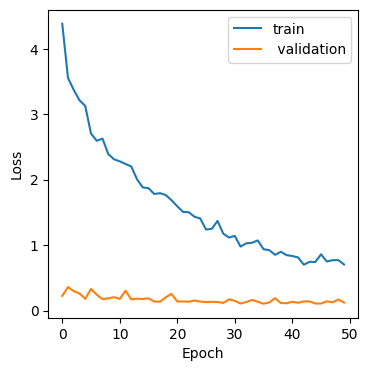

In [108]:
# Our data are small but it seems we can continue training further since the graph below still shows
# that the model can still learn, i.e., underfit due to early training termination
fig, ax=plt.subplots(figsize=(4,4))
for name, losses in zip('train, validation'.split(','),[train_losses, val_losses]):
    losses=[l.detach().cpu() if isinstance(l, torch.Tensor) else l for l in losses]
    ax.plot(losses, label=name)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
plt.legend(loc="upper right")

### Inference

Out test data is the same as validation data for this quick test on a small data, which is not how we should partition data typically

In [64]:
def alpha_bending(foreground, background, alpha):
    '''
    Args:
        foreground (Tensor): NxCxHxW image to be on the foreground
        background (Tensor): NxCxHxW image to be on the background
        alpha (float): opacity of the foreground
    '''
    background=background.to(torch.float32)
    foreground=foreground.to(torch.float32)
    C=max(background.shape[1], foreground.shape[1])
    output=torch.zeros(background.shape[0], C, *background.shape[-2:], dtype=background.dtype,
                       device=background.device)
    if foreground.shape[1]!=C: foreground=foreground.expand(foreground.shape[0],1,*foreground.shape[-2:])
    if background.shape[1]!=C: background=background.expand(background.shape[0],1,*background.shape[-2:])
    return background*(1.-alpha)+foreground*alpha


In [23]:
model.eval()
test_dataset=PennFudanDataset(root=os.path.join(main_dirpath, 'PennFudanPed'), image_dirname='PNGImages', mask_dirname='PedMasks',
                               annotation_dirname='Annotation', transforms=get_transform(is_train=False), indices=np.arange(160,170))

test_loader=torch.utils.data.DataLoader(val_dataset, batch_size=1,shuffle=False,collate_fn=utils.collate_fn)

In [90]:
all_input_images=[]
all_outputs=[]
for indx, (images, targets) in enumerate(test_loader):
    images=[im.to(device) for im in images]
    with torch.no_grad(): outputs=model(images)
    all_input_images.append(images)
    all_outputs.append(outputs)

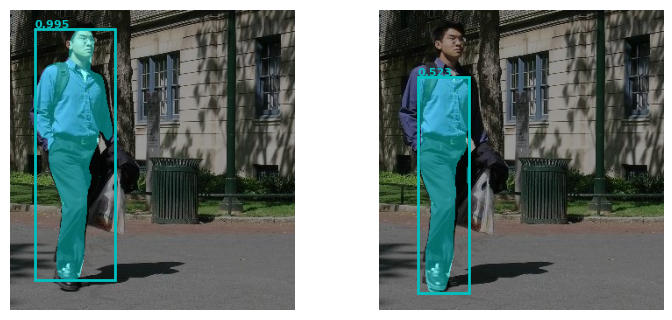

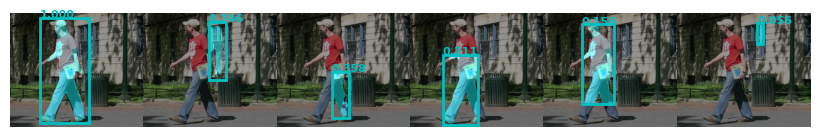

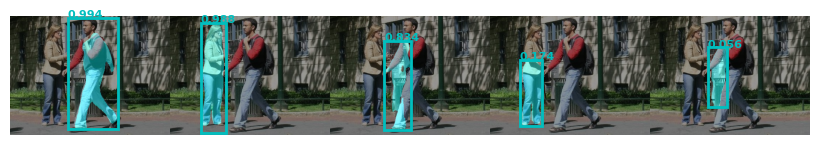

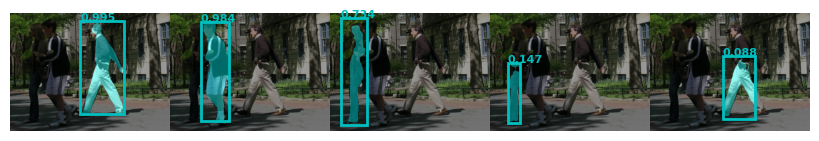

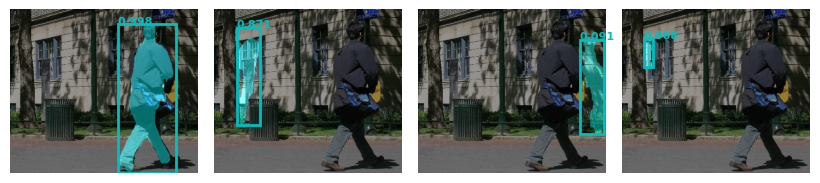

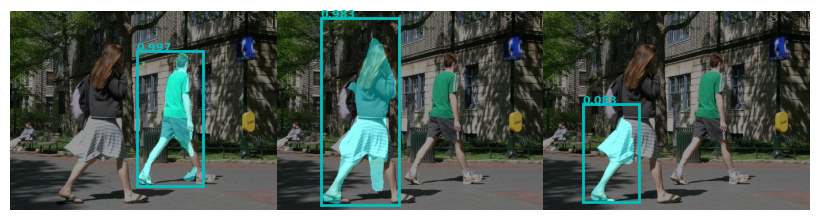

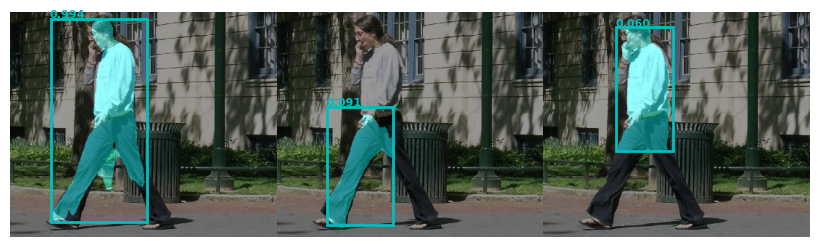

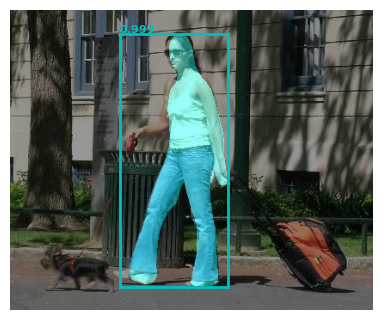

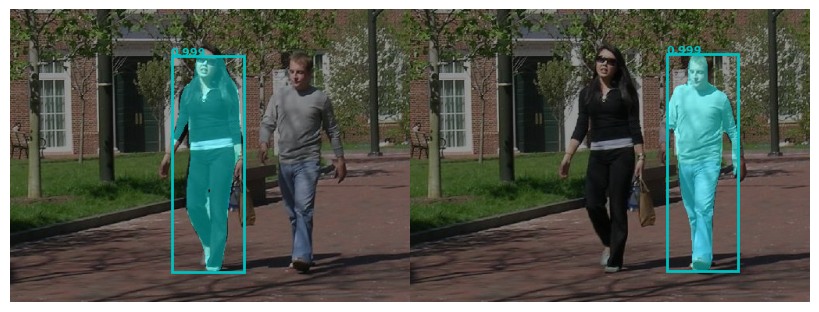

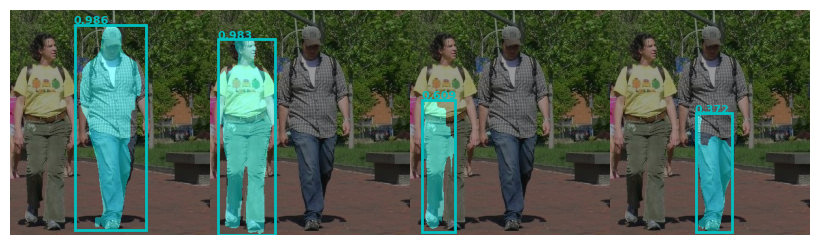

In [100]:
import matplotlib.patches as patches

# visualize outputs

alpha=0.4
for i, (images,outputs) in enumerate(zip(all_input_images,all_outputs)):

    for image, output in zip(images, outputs):

        # turn heatmap to segmentation
        mask=(output['masks']>0.5).to(dtype=torch.uint8) # Nx1xHxW where N is the number of boxes
        # make binary mask RGB channel of cyan
        mask=torch.cat([torch.zeros_like(mask), mask, mask], dim=1) # NxCxHxW where C is RBG channels
        # convert CxHxW -> NxCxHxW
        background=image.unsqueeze(0).expand(output['masks'].shape[0], *image.shape)
        alpha_img=alpha_bending(foreground=mask, background=background, alpha=alpha)

        # boxes
        boxes=output['boxes'].cpu()
        x,y=boxes[:,0], boxes[:,1]
        size=boxes[:,2:]-boxes[:,:2]
        width, height=size[:,0], size[:,1]

        # scores
        scores=output['scores'].cpu()


        # visualize output
        fig, axes=plt.subplots(1, alpha_img.shape[0], figsize=(8,3))
        for i, al_im in enumerate(alpha_img):
            try: ax=axes[i]
            except: ax=axes
            ax.imshow(al_im.permute(1,2,0).cpu()) # CxHxW -> HxWxC
            rect = patches.Rectangle((x[i], y[i]), width[i], height[i], linewidth=2, edgecolor='c', facecolor='none')
            ax.add_patch(rect)
            ax.text(x[i]-1, y[i]-1, s=f'{scores[i]:.3f}', fontsize=8, fontweight='bold', color='c')
            ax.axis('off')
        plt.tight_layout(pad=0, w_pad=0, h_pad=0)


In [11]:
# model.load_state_dict(torch.load('checkpoint.pth', weights_only=True))